
Evaluating Random Forest...
Best Parameters for Random Forest: {'randomforestclassifier__max_depth': None, 'randomforestclassifier__n_estimators': 200}
Best Cross-validation Score for Random Forest: 0.5352099728467355


/data/home/farhan.arsyi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/farhan.arsyi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/farhan.arsyi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

              precision    recall  f1-score   support

          BL       0.50      0.03      0.05        35
           G       0.59      0.68      0.63       155
           H       0.55      0.76      0.64       185
          NP       0.68      0.36      0.47        47
          NV       0.00      0.00      0.00        17
          PL       0.56      0.48      0.52       104
          V1       0.49      0.52      0.50       124
          V2       0.51      0.41      0.45       100

    accuracy                           0.55       767
   macro avg       0.48      0.41      0.41       767
weighted avg       0.54      0.55      0.52       767



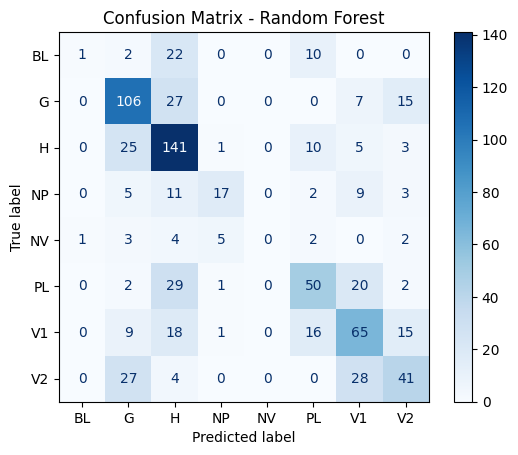

Predicted Probabilities for Random Forest:
      BL      G      H     NP     NV     PL     V1     V2
0  0.175  0.055  0.275  0.200  0.060  0.190  0.035  0.010
1  0.050  0.315  0.305  0.055  0.010  0.075  0.095  0.095
2  0.010  0.080  0.170  0.105  0.020  0.195  0.320  0.100
3  0.050  0.115  0.120  0.115  0.025  0.175  0.275  0.125
4  0.055  0.130  0.190  0.090  0.065  0.245  0.175  0.050

Evaluating Gradient Boosting...


KeyboardInterrupt: 

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sktime.transformations.panel.rocket import Rocket
from sktime.datatypes._panel._convert import from_2d_array_to_nested
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Load the dataset
data = pd.read_csv('../../00_Data_Input/relabelled_data_ksa_explore.csv')

# Preparing data for modeling
X = data[[f'VH_{i}' for i in range(31)]]
y = data['class']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Convert the data to nested DataFrame format required by sktime
X_train_nested = from_2d_array_to_nested(X_train.to_numpy())
X_test_nested = from_2d_array_to_nested(X_test.to_numpy())

# Applying Rocket transformation
rocket = Rocket(num_kernels=1000)
X_train_transform = rocket.fit_transform(X_train_nested)
X_test_transform = rocket.transform(X_test_nested)

# Define alternative models
models = {
    # 'Logistic Regression': LogisticRegression(solver='saga',max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
}

# Define parameter grids for each model
param_grids = {
    # 'Logistic Regression': {
    #     'logisticregression__C': [0.01, 0.1, 1.0, 10.0],
    # },
    'Random Forest': {
        'randomforestclassifier__n_estimators': [50, 100, 200],
        'randomforestclassifier__max_depth': [None, 10, 20],
    },
    'Gradient Boosting': {
        'gradientboostingclassifier__n_estimators': [50, 100, 200],
        'gradientboostingclassifier__learning_rate': [0.01, 0.1, 0.2],
    },
}

# Evaluate each model using GridSearchCV
best_models = {}
for model_name, model in models.items():
    print(f"\nEvaluating {model_name}...")
    
    # Build the pipeline
    pipeline = make_pipeline(StandardScaler(with_mean=False), model)
    
    # Perform GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grids[model_name], cv=5, n_jobs=10)
    grid_search.fit(X_train_transform, y_train)
    
    # Store the best model
    best_models[model_name] = grid_search
    
    # Output the best parameters and score
    print(f"Best Parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best Cross-validation Score for {model_name}: {grid_search.best_score_}")
    
    # Evaluating the model on the test set
    y_pred = grid_search.predict(X_test_transform)
    y_prob = grid_search.predict_proba(X_test_transform) if hasattr(grid_search, "predict_proba") else None
    
    # Classification report
    print(classification_report(y_test, y_pred))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=grid_search.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_search.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()
    
    # Display predicted probabilities if available
    if y_prob is not None:
        print(f"Predicted Probabilities for {model_name}:")
        print(pd.DataFrame(y_prob, columns=grid_search.classes_).head())

# Compare the best cross-validation scores of all models
for model_name, grid_search in best_models.items():
    print(f"Best Cross-validation Score for {model_name}: {grid_search.best_score_}")
